In [47]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Activation,Dropout,BatchNormalization
from tensorflow.keras import regularizers

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import os
import time
import shutil
import pathlib
import itertools

In [49]:
data_dir = "C:/Users/aniru/OneDrive/Desktop/Data"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath =  os.path.join(data_dir,fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels,name='labels')
df = pd.concat([Fseries,Lseries],axis = 1)


In [51]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)


In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)



# Create an ImageDataGenerator with augmentation
# Define correct ImageDataGenerator for train and test
tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator(rescale=1./255)

# Correct generators
train_gen = tr_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator


Found 808 validated image filenames belonging to 2 classes.
Found 203 validated image filenames belonging to 2 classes.


In [55]:
from sklearn.utils.class_weight import compute_class_weight

# Find unique class indices
class_indices = list(train_gen.class_indices.values())

# Compute class weights automatically
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

# Map them into a dictionary
class_weights = dict(zip(class_indices, class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 1.9330143540669857, 1: 0.674457429048414}


In [58]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.ResNet50(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24,120,962
Trainable params: 24,063,746
Non-trainable params: 57,216
_____________________________________

In [60]:
history = model.fit(x = train_gen,epochs = 30,verbose= 1,validation_data = test_gen,validation_steps = 10,shuffle= False,class_weight=class_weights)


Epoch 1/30
101/101 [==============================] - 22s 171ms/step - loss: 8.6571 - accuracy: 0.5557 - val_loss: 7.3275 - val_accuracy: 0.7375
Epoch 2/30
101/101 [==============================] - 17s 163ms/step - loss: 7.2064 - accuracy: 0.6077 - val_loss: 13.4035 - val_accuracy: 0.7375
Epoch 3/30
101/101 [==============================] - 16s 163ms/step - loss: 6.7274 - accuracy: 0.6052 - val_loss: 6.1890 - val_accuracy: 0.7375
Epoch 4/30
101/101 [==============================] - 16s 163ms/step - loss: 6.2531 - accuracy: 0.6337 - val_loss: 5.5108 - val_accuracy: 0.7375
Epoch 5/30
101/101 [==============================] - 16s 163ms/step - loss: 5.6091 - accuracy: 0.6324 - val_loss: 5.2978 - val_accuracy: 0.7375
Epoch 6/30
101/101 [==============================] - 17s 163ms/step - loss: 5.1595 - accuracy: 0.6696 - val_loss: 4.5876 - val_accuracy: 0.7375
Epoch 7/30
101/101 [==============================] - 17s 163ms/step - loss: 4.8738 - accuracy: 0.6374 - val_loss: 4.3674 - val_a

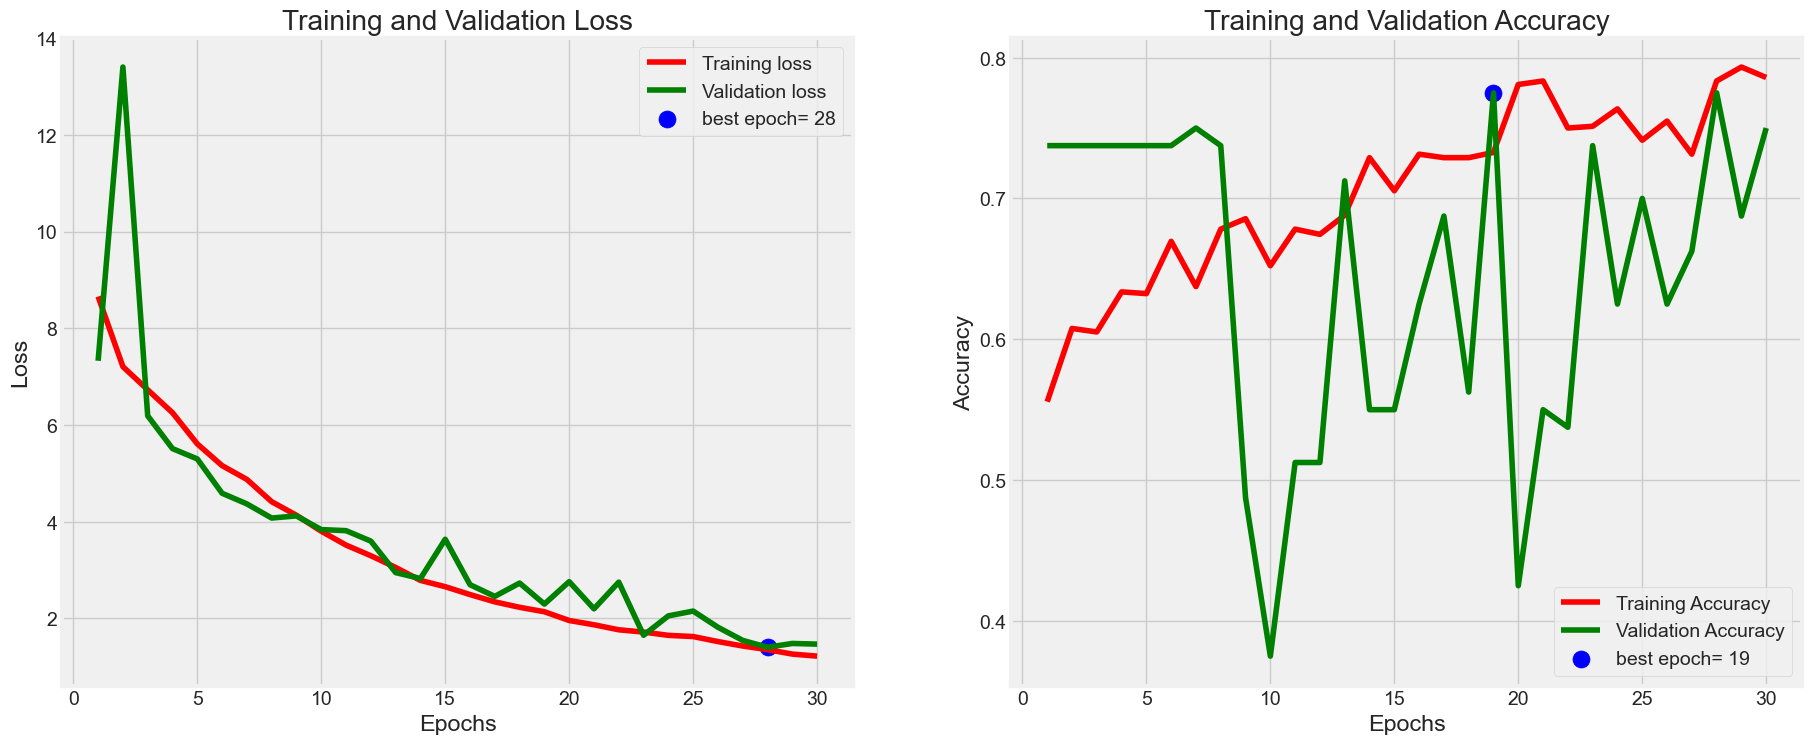

In [61]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


26/26 [==============================] - 1s 47ms/step - loss: 1.3889 - accuracy: 0.7931
Train Loss:  1.1125692129135132
Train Accuracy:  0.8601484894752502
--------------------
Test Loss:  1.3889100551605225
Test Accuracy:  0.7931034564971924
26/26 [==============================] - 2s 45ms/step


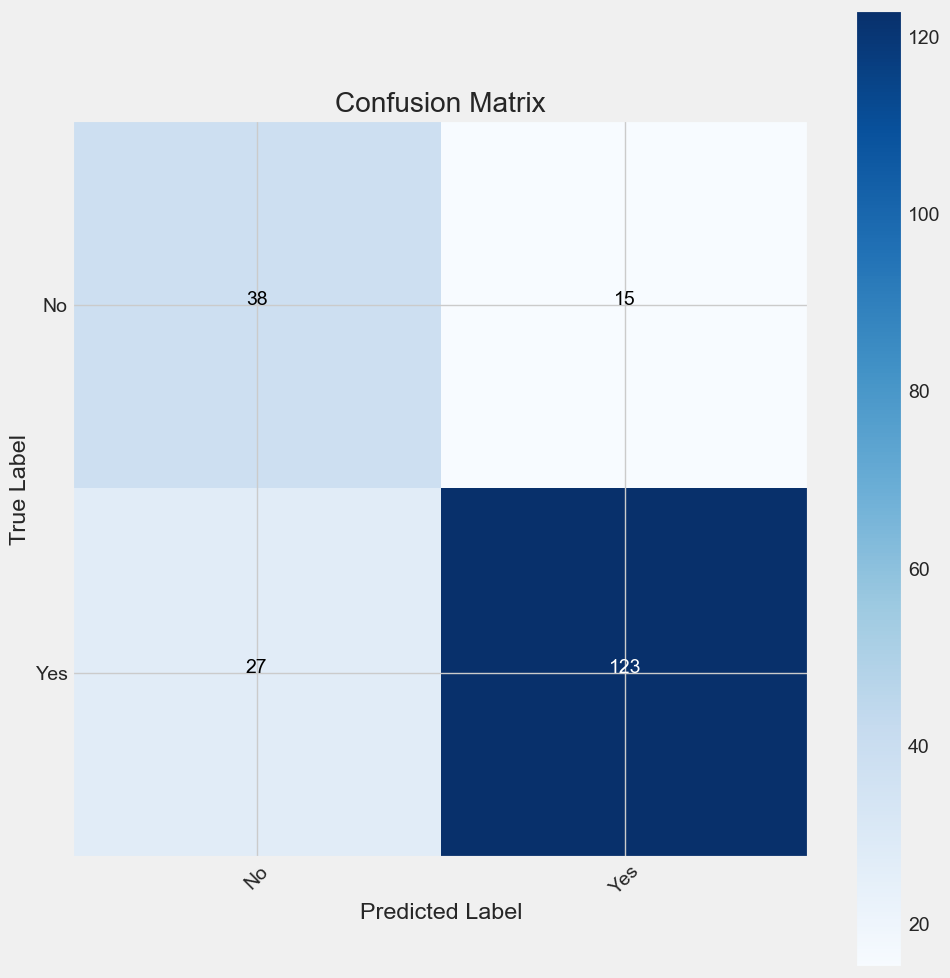

In [63]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()



In [64]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          No       0.58      0.72      0.64        53
         Yes       0.89      0.82      0.85       150

    accuracy                           0.79       203
   macro avg       0.74      0.77      0.75       203
weighted avg       0.81      0.79      0.80       203

